### 0) Setup & Imports

In [ ]:
%pip install -q imbalanced-learn lightgbm xgboost joblib

import os
import sys
import numpy as np
import pandas as pd
from pathlib import Path

from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    classification_report, roc_auc_score, average_precision_score,
    confusion_matrix, RocCurveDisplay, PrecisionRecallDisplay, ConfusionMatrixDisplay
)
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from imblearn.over_sampling import SMOTE

# Optional: silence noisy warnings
import warnings
warnings.filterwarnings("ignore")

# Project imports
ROOT = Path("..").resolve()
sys.path.append(str(ROOT / "src"))

from data_collection import load_raw_data
from data_preprocessing import preprocess
from feature_engineering import add_features

MODELS_DIR = ROOT / "models"
MODELS_DIR.mkdir(exist_ok=True)


Note: you may need to restart the kernel to use updated packages.


### 1) Load → Preprocess → Feature Engineering

In [17]:
# Load raw Kaggle CSV (adjust path if needed)
df = load_raw_data(str(ROOT / "data" / "raw" / "fraudulent_transactions.csv"))

# Our preprocessing maps Kaggle columns -> project schema
df = preprocess(df)
df = add_features(df)

print("Shape:", df.shape)
df.head(3)


Processed dataframe shape: (6362620, 13)
Fraud distribution:
 TX_FRAUD
0    0.998709
1    0.001291
Name: proportion, dtype: float64
Shape: (6362620, 19)


,TX_STEP,type,TX_AMOUNT,CUSTOMER_ID,oldbalanceOrg,newbalanceOrig,TERMINAL_ID,oldbalanceDest,newbalanceDest,TX_FRAUD,isFlaggedFraud,TX_DAY,TX_HOUR,cust_mean_amount,cust_std_amount,cust_tx_count,terminal_fraud_ratio,terminal_tx_count,cust_daily_spend
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0,0,1,9839.64,NaN,1,0.000000,1,9839.64
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0,0,1,1864.28,NaN,1,0.000000,1,1864.28
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0,0,1,181.00,NaN,1,0.022727,44,181.00


In [19]:
import os
import pandas as pd

# Save processed features for model.py and evaluation.py
processed_dir = "data/processed"
os.makedirs(processed_dir, exist_ok=True)

processed_path = os.path.join(processed_dir, "transactions_features.csv")
df.to_csv(processed_path, index=False)
print(f"Processed features saved to {processed_path}")

# Save feature list (exclude target)
feature_cols = [col for col in df.columns if col != "TX_FRAUD"]
os.makedirs("models", exist_ok=True)
feature_list_path = os.path.join("models", "feature_list.csv")
pd.DataFrame(feature_cols).to_csv(feature_list_path, index=False)
print(f"Feature list saved to {feature_list_path}")


Processed features saved to data/processed\transactions_features.csv
Feature list saved to models\feature_list.csv


### 2) Train/Val/Test Split (time-aware via TX_STEP/TX_DAY if present)

<p>Here we’re doing a chronological split by TX_STEP (hours). If unavailable, we’ll fall back to a stratified split.</P>

In [3]:
use_time_split = "TX_STEP" in df.columns

target_col = "TX_FRAUD"
feature_cols = [
    "TX_AMOUNT",
    "cust_mean_amount", "cust_std_amount", "cust_tx_count",
    "terminal_fraud_ratio", "terminal_tx_count",
    "cust_daily_spend",
    # Optional raw time features (harmless for trees)
    *([c for c in ["TX_STEP", "TX_DAY", "TX_HOUR"] if c in df.columns])
]

X_all = df[feature_cols].copy()
y_all = df[target_col].copy()

# Fill NaNs (e.g., std at singletons)
X_all = X_all.fillna(0)

if use_time_split:
    df_sorted = df.sort_values("TX_STEP").reset_index(drop=True)
    N = len(df_sorted)
    tr_end = int(0.7 * N)
    va_end = int(0.85 * N)

    train_df = df_sorted.iloc[:tr_end]
    val_df   = df_sorted.iloc[tr_end:va_end]
    test_df  = df_sorted.iloc[va_end:]

    X_train, y_train = train_df[feature_cols].fillna(0), train_df[target_col]
    X_val,   y_val   = val_df[feature_cols].fillna(0),   val_df[target_col]
    X_test,  y_test  = test_df[feature_cols].fillna(0),  test_df[target_col]
else:
    X_temp, X_test, y_temp, y_test = train_test_split(
        X_all, y_all, test_size=0.15, random_state=42, stratify=y_all
    )
    X_train, X_val, y_train, y_val = train_test_split(
        X_temp, y_temp, test_size=0.1765, random_state=42, stratify=y_temp
    )  # 0.1765 of 0.85 ≈ 0.15

print("Train/Val/Test sizes:", len(X_train), len(X_val), len(X_test))
print("Fraud ratios (train/val/test):",
      y_train.mean().round(4), y_val.mean().round(4), y_test.mean().round(4))


Train/Val/Test sizes: 4453834 954393 954393
Fraud ratios (train/val/test): 0.0008 0.0006 0.0042


### 3) Utilities (metrics, reports, threshold sweep, pos_weight)

In [4]:
def metrics_report(y_true, y_prob, y_pred=None):
    if y_pred is None:
        y_pred = (y_prob >= 0.5).astype(int)
    roc = roc_auc_score(y_true, y_prob)
    pr  = average_precision_score(y_true, y_prob)
    cm  = confusion_matrix(y_true, y_pred)
    rep = classification_report(y_true, y_pred, digits=4)
    return {"roc_auc": roc, "pr_auc": pr, "cm": cm, "report": rep}

def best_threshold_under_fpr(y_true, y_prob, max_fpr=0.005, fp_cost=1.0, fn_cost=25.0, grid=2000):
    """Scan thresholds to minimize cost, subject to FPR <= max_fpr."""
    y_true = np.asarray(y_true)
    y_prob = np.asarray(y_prob)
    thresholds = np.linspace(0, 1, grid)
    best = {"thr": 0.5, "cost": np.inf, "fpr": None, "recall": None, "precision": None}

    P = (y_true == 1).sum()
    N = (y_true == 0).sum()

    for t in thresholds:
        pred = (y_prob >= t).astype(int)
        TP = np.sum((pred == 1) & (y_true == 1))
        FP = np.sum((pred == 1) & (y_true == 0))
        FN = np.sum((pred == 0) & (y_true == 1))
        TN = np.sum((pred == 0) & (y_true == 0))

        fpr = FP / (FP + TN + 1e-12)
        if fpr <= max_fpr:
            cost = fp_cost * FP + fn_cost * FN
            precision = TP / (TP + FP + 1e-12)
            recall = TP / (TP + FN + 1e-12)
            if cost < best["cost"]:
                best.update({"thr": t, "cost": cost, "fpr": fpr, "recall": recall, "precision": precision})
    return best

def get_scale_pos_weight(y):
    neg = (y == 0).sum()
    pos = (y == 1).sum()
    return max(1.0, neg / max(1, pos))


### 4)  — Baselines (LogReg + small RF)

In [5]:
from sklearn.pipeline import Pipeline

# Standardize only for linear model (tree models don't need scaling)
scaler = StandardScaler()

# 1) Logistic Regression (balanced)
logreg_pipe = Pipeline([
    ("scaler", scaler),
    ("clf", LogisticRegression(max_iter=1000, class_weight="balanced", n_jobs=None, solver="lbfgs"))
])

logreg_pipe.fit(X_train, y_train)
lr_val_prob = logreg_pipe.predict_proba(X_val)[:, 1]
lr_test_prob = logreg_pipe.predict_proba(X_test)[:, 1]

lr_val_metrics = metrics_report(y_val, lr_val_prob)
lr_test_metrics = metrics_report(y_test, lr_test_prob)

print("LogReg — VAL:  ROC-AUC:", lr_val_metrics["roc_auc"], " PR-AUC:", lr_val_metrics["pr_auc"])
print("LogReg — TEST: ROC-AUC:", lr_test_metrics["roc_auc"], " PR-AUC:", lr_test_metrics["pr_auc"])
print(lr_test_metrics["report"])

# 2) Small RandomForest (balanced)
rf = RandomForestClassifier(
    n_estimators=200, max_depth=12, min_samples_leaf=5,
    class_weight="balanced", n_jobs=-1, random_state=42
)
rf.fit(X_train, y_train)
rf_val_prob = rf.predict_proba(X_val)[:, 1]
rf_test_prob = rf.predict_proba(X_test)[:, 1]

rf_val_metrics = metrics_report(y_val, rf_val_prob)
rf_test_metrics = metrics_report(y_test, rf_test_prob)

print("RF — VAL:  ROC-AUC:", rf_val_metrics["roc_auc"], " PR-AUC:", rf_val_metrics["pr_auc"])
print("RF — TEST: ROC-AUC:", rf_test_metrics["roc_auc"], " PR-AUC:", rf_test_metrics["pr_auc"])
print(rf_test_metrics["report"])


LogReg — VAL:  ROC-AUC: 0.9988313108430034  PR-AUC: 0.3218700268659378
LogReg — TEST: ROC-AUC: 0.9988467471322618  PR-AUC: 0.7161778850664859
              precision    recall  f1-score   support

           0     0.9999    0.9939    0.9969    950383
           1     0.4026    0.9796    0.5707      4010

    accuracy                         0.9938    954393
   macro avg     0.7013    0.9867    0.7838    954393
weighted avg     0.9974    0.9938    0.9951    954393

RF — VAL:  ROC-AUC: 0.9987495240255572  PR-AUC: 0.592817076434834
RF — TEST: ROC-AUC: 0.9990238960833911  PR-AUC: 0.836400127660897
              precision    recall  f1-score   support

           0     0.9995    0.9974    0.9984    950383
           1     0.5853    0.8863    0.7050      4010

    accuracy                         0.9969    954393
   macro avg     0.7924    0.9418    0.8517    954393
weighted avg     0.9978    0.9969    0.9972    954393



### 5) — Main Learners (LightGBM + XGBoost)

In [6]:
# LIGHTGBM (CPU)
import lightgbm as lgb

lgb_pos_weight = get_scale_pos_weight(y_train)

lgbm = lgb.LGBMClassifier(
    objective="binary",
    metric=["auc", "average_precision"],
    is_unbalance=True,               # or set scale_pos_weight=lgb_pos_weight
    learning_rate=0.05,
    num_leaves=64,
    max_depth=-1,
    min_data_in_leaf=200,
    feature_fraction=0.6,
    bagging_fraction=0.8,
    bagging_freq=1,
    n_estimators=3000,
    n_jobs=-1,
    random_state=42
)

lgbm.fit(
    X_train, y_train,
    eval_set=[(X_val, y_val)],
    eval_metric=["auc", "average_precision"],
    callbacks=[lgb.early_stopping(stopping_rounds=200, verbose=False)]
)

lgb_val_prob = lgbm.predict_proba(X_val)[:, 1]
lgb_test_prob = lgbm.predict_proba(X_test)[:, 1]

lgb_val_metrics = metrics_report(y_val, lgb_val_prob)
lgb_test_metrics = metrics_report(y_test, lgb_test_prob)

print("LightGBM — VAL:  ROC-AUC:", lgb_val_metrics["roc_auc"], " PR-AUC:", lgb_val_metrics["pr_auc"])
print("LightGBM — TEST: ROC-AUC:", lgb_test_metrics["roc_auc"], " PR-AUC:", lgb_test_metrics["pr_auc"])
print(lgb_test_metrics["report"])


[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] feature_fraction is set=0.6, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] feature_fraction is set=0.6, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Info] Number of positive: 3639, number of 

In [10]:
import xgboost
from xgboost import XGBClassifier

print("XGBoost version:", xgboost.__version__)

xgb_pos_weight = get_scale_pos_weight(y_train)

xgb_params = dict(
    objective="binary:logistic",
    eval_metric=["aucpr", "auc"],
    tree_method="gpu_hist",
    predictor="gpu_predictor",
    max_depth=6,
    max_bin=256,
    subsample=0.8,
    colsample_bytree=0.6,
    learning_rate=0.05,
    scale_pos_weight=xgb_pos_weight,
    n_estimators=3000,
    random_state=42,
)

try:
    xgb = XGBClassifier(**xgb_params)

    # Handle early stopping depending on XGBoost version
    if int(xgboost.__version__.split(".")[1]) >= 6:  # >= 1.6
        xgb.fit(
            X_train, y_train,
            eval_set=[(X_val, y_val)],
            verbose=False,
            early_stopping_rounds=200
        )
    else:
        # For older versions, early_stopping_rounds is not supported
        xgb.fit(
            X_train, y_train,
            eval_set=[(X_val, y_val)],
            verbose=False
        )
        print("⚠️ Warning: early_stopping_rounds not supported in this XGBoost version.")
except Exception as e:
    print("GPU training failed; falling back to CPU 'hist'. Reason:", str(e))
    xgb_params.update(dict(tree_method="hist", predictor="auto"))
    xgb = XGBClassifier(**xgb_params)
    xgb.fit(X_train, y_train, eval_set=[(X_val, y_val)], verbose=False)

# Predictions
xgb_val_prob = xgb.predict_proba(X_val)[:, 1]
xgb_test_prob = xgb.predict_proba(X_test)[:, 1]

xgb_val_metrics = metrics_report(y_val, xgb_val_prob)
xgb_test_metrics = metrics_report(y_test, xgb_test_prob)

print("XGBoost — VAL:  ROC-AUC:", xgb_val_metrics["roc_auc"], " PR-AUC:", xgb_val_metrics["pr_auc"])
print("XGBoost — TEST: ROC-AUC:", xgb_test_metrics["roc_auc"], " PR-AUC:", xgb_test_metrics["pr_auc"])
print(xgb_test_metrics["report"])


XGBoost version: 3.0.1
GPU training failed; falling back to CPU 'hist'. Reason: [22:45:36] C:\b\abs_d97hy_84m6\croot\xgboost-split_1749630932152\work\src\common\common.h:181: XGBoost version not compiled with GPU support.
XGBoost — VAL:  ROC-AUC: 0.9991083957991816  PR-AUC: 0.7165962572970183
XGBoost — TEST: ROC-AUC: 0.9992726529941861  PR-AUC: 0.9124804743302795
              precision    recall  f1-score   support

           0     0.9991    0.9997    0.9994    950383
           1     0.9140    0.7766    0.8397      4010

    accuracy                         0.9988    954393
   macro avg     0.9565    0.8881    0.9195    954393
weighted avg     0.9987    0.9988    0.9987    954393



### 6) Simple Soft-Vote Ensemble (RF + XGB)

In [11]:
ens_val_prob  = (rf_val_prob + xgb_val_prob) / 2.0
ens_test_prob = (rf_test_prob + xgb_test_prob) / 2.0

ens_val_metrics = metrics_report(y_val, ens_val_prob)
ens_test_metrics = metrics_report(y_test, ens_test_prob)

print("Ensemble — VAL:  ROC-AUC:", ens_val_metrics["roc_auc"], " PR-AUC:", ens_val_metrics["pr_auc"])
print("Ensemble — TEST: ROC-AUC:", ens_test_metrics["roc_auc"], " PR-AUC:", ens_test_metrics["pr_auc"])
print(ens_test_metrics["report"])


Ensemble — VAL:  ROC-AUC: 0.9989509508778016  PR-AUC: 0.7069025730957341
Ensemble — TEST: ROC-AUC: 0.9993000400366218  PR-AUC: 0.8982668082192378
              precision    recall  f1-score   support

           0     0.9991    0.9996    0.9994    950383
           1     0.8951    0.7913    0.8400      4010

    accuracy                         0.9987    954393
   macro avg     0.9471    0.8954    0.9197    954393
weighted avg     0.9987    0.9987    0.9987    954393



### 7) — Threshold Sweep + Cost-Based Evaluation
<p>Here we’ll sweep thresholds on the validation set to pick the best threshold under an FPR constraint, then evaluate on test.</p>

In [12]:
FP_COST = 1.0
FN_COST = 25.0
MAX_FPR = 0.005

# Choose which model's probabilities to optimize (use the best VAL PR-AUC or ROC-AUC)
candidates = {
    "LogReg": (lr_val_prob, lr_test_prob),
    "RF":     (rf_val_prob, rf_test_prob),
    "LGBM":   (lgb_val_prob, lgb_test_prob),
    "XGB":    (xgb_val_prob, xgb_test_prob),
    "ENS":    (ens_val_prob, ens_test_prob)
}

# Pick best by VAL PR-AUC (you can change to ROC-AUC)
best_name = None
best_val_score = -np.inf
for name, (val_prob, _) in candidates.items():
    score = average_precision_score(y_val, val_prob)
    if score > best_val_score:
        best_val_score = score
        best_name = name

print(f"Selected for threshold tuning by VAL PR-AUC: {best_name}")

val_prob, test_prob = candidates[best_name]

# Find threshold on VAL
best_val = best_threshold_under_fpr(y_val, val_prob, MAX_FPR, FP_COST, FN_COST, grid=2000)
print("Best threshold on VAL:", best_val)

# Apply on TEST
thr = best_val["thr"]
test_pred = (test_prob >= thr).astype(int)
TP = np.sum((test_pred==1) & (y_test==1))
FP = np.sum((test_pred==1) & (y_test==0))
FN = np.sum((test_pred==0) & (y_test==1))
TN = np.sum((test_pred==0) & (y_test==0))

fpr = FP / (FP + TN + 1e-12)
recall = TP / (TP + FN + 1e-12)
precision = TP / (TP + FP + 1e-12)
cost = FP_COST*FP + FN_COST*FN

print(f"TEST @ thr={thr:.4f}  FPR={fpr:.6f}  Recall={recall:.4f}  Precision={precision:.4f}  Cost={cost:.1f}")


Selected for threshold tuning by VAL PR-AUC: XGB
Best threshold on VAL: {'thr': 0.015507753876938469, 'cost': 4001.0, 'fpr': 0.0008921934644469816, 'recall': 0.7765957446808497, 'precision': 0.3397982932505816}
TEST @ thr=0.0155  FPR=0.001131  Recall=0.8618  Precision=0.7627  Cost=14925.0


### 8) Plots (Confusion Matrix, ROC, PR) — on Test for the Selected Model

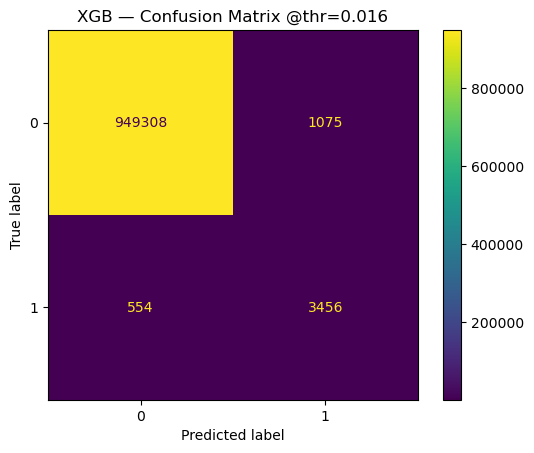

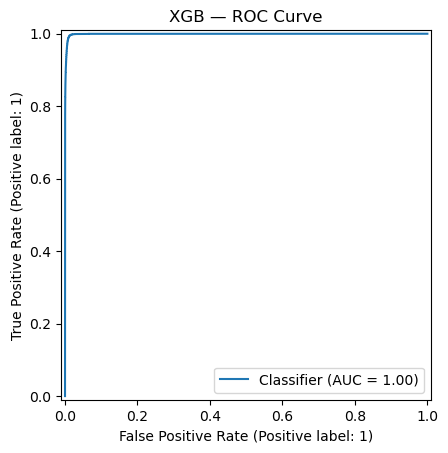

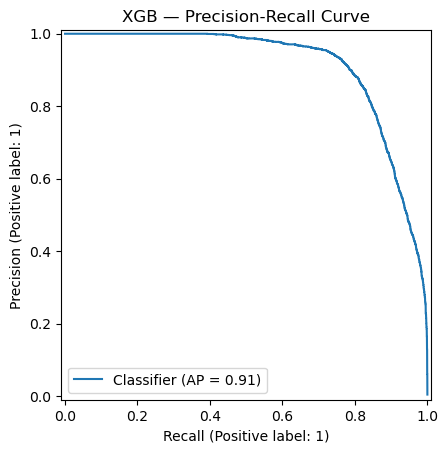

In [13]:
# Compute y_pred for the chosen model on TEST
chosen_test_prob = test_prob  # from candidates selection above
chosen_test_pred = (chosen_test_prob >= thr).astype(int)

# Confusion Matrix
ConfusionMatrixDisplay.from_predictions(y_test, chosen_test_pred)
import matplotlib.pyplot as plt
plt.title(f"{best_name} — Confusion Matrix @thr={thr:.3f}")
plt.show()

# ROC Curve
RocCurveDisplay.from_predictions(y_test, chosen_test_prob)
plt.title(f"{best_name} — ROC Curve")
plt.show()

# Precision-Recall Curve
PrecisionRecallDisplay.from_predictions(y_test, chosen_test_prob)
plt.title(f"{best_name} — Precision-Recall Curve")
plt.show()


### 9) Save Artifacts (Scaler + Best Model)
<p> We save the scaler (for LogReg) and the selected model used for thresholding.<br>
If the selected model is tree-based (RF/LGBM/XGB/ENS), we still save a dummy scaler to keep the interface consistent.</P>

In [14]:
import joblib

# Decide which estimator object to save
if best_name == "LogReg":
    best_estimator = logreg_pipe
elif best_name == "RF":
    best_estimator = rf
elif best_name == "LGBM":
    best_estimator = lgbm
elif best_name == "XGB":
    best_estimator = xgb
else:  # "ENS"
    # Save both base models and we’ll ensemble at inference
    joblib.dump(rf, MODELS_DIR / "RF.pkl")
    joblib.dump(xgb, MODELS_DIR / "XGB.pkl")
    # Save a small wrapper for ensemble predictions
    best_estimator = None

# Save the selected model (if not ensemble wrapper)
if best_estimator is not None:
    joblib.dump(best_estimator, MODELS_DIR / f"{best_name}.pkl")
    print(f"Saved model: {MODELS_DIR / f'{best_name}.pkl'}")

# Save scaler only if the selected is LogReg pipeline; otherwise, save a pass-through marker
if best_name == "LogReg":
    # The scaler is inside the pipeline; no separate scaler needed
    pass
else:
    # Save a noop marker for interface consistency
    joblib.dump({"note": "no-scaler-needed-for-tree-models"}, MODELS_DIR / "scaler.pkl")

# Save threshold & feature list for inference
np.save(MODELS_DIR / "best_threshold.npy", np.array([thr], dtype=float))
pd.Series(feature_cols).to_csv(MODELS_DIR / "feature_list.csv", index=False, header=False)
print("Saved threshold and feature list.")


Saved model: D:\STUDY\Data Science\Internship Projects\Github Upload\Fraud Transaction Detection\models\XGB.pkl
Saved threshold and feature list.


### 10) Quick Inference Function (for later API)

In [15]:
def predict_proba_inference(df_new: pd.DataFrame, model_name: str, models_dir=MODELS_DIR):
    """
    df_new should already have the engineered feature columns.
    Returns probabilities and binary predictions using the saved threshold.
    """
    thr = float(np.load(models_dir / "best_threshold.npy"))
    feats = pd.read_csv(models_dir / "feature_list.csv", header=None)[0].tolist()
    Xn = df_new[feats].fillna(0)

    if model_name == "LogReg":
        model = joblib.load(models_dir / "LogReg.pkl")
        proba = model.predict_proba(Xn)[:, 1]
    elif model_name == "RF":
        model = joblib.load(models_dir / "RF.pkl")
        proba = model.predict_proba(Xn)[:, 1]
    elif model_name == "LGBM":
        model = joblib.load(models_dir / "LGBM.pkl")
        proba = model.predict_proba(Xn)[:, 1]
    elif model_name == "XGB":
        model = joblib.load(models_dir / "XGB.pkl")
        proba = model.predict_proba(Xn)[:, 1]
    else:
        # Ensemble RF + XGB
        rf_m = joblib.load(models_dir / "RF.pkl")
        xgb_m = joblib.load(models_dir / "XGB.pkl")
        proba = (rf_m.predict_proba(Xn)[:, 1] + xgb_m.predict_proba(Xn)[:, 1]) / 2.0

    pred = (proba >= thr).astype(int)
    return proba, pred
